In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, SimpleRNN, GRU, LSTM, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [2]:
vocab_size = 10000      # vocal 사이즈
num_pad =  200          # Sequence_length
num_embeddings = 100   # 임베딩 벡터의 차원
dropout_ratio = 0.3    # 드롭아웃 비율
num_filters = 30       # 커널의 수
kernel_size = 3        # 커널의 크기
hidden_units = 60      # 뉴런의 수

nsize = 5000           # resize data 

In [3]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

print(len(X_train), "train sequences")
print(len(X_test), "test sequences")
print(np.max(y_train)+1, "classes")

25000 train sequences
25000 test sequences
2 classes


In [4]:
X_train = X_train[:nsize]
y_train = y_train[:nsize]
X_test = X_test[:nsize]
y_test = y_test[:nsize]

print(f"훈련 샘플 수: {len(X_train)}, 테스트 샘플 수: {len(X_test)}")

훈련 샘플 수: 5000, 테스트 샘플 수: 5000


In [5]:
print(X_train[0][:20])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]


In [6]:
X_train = pad_sequences(X_train, maxlen=num_pad)
X_test =  pad_sequences(X_test, maxlen=num_pad)

print("x_train shape:", X_train.shape)
print("x_test shape:", X_test.shape)

x_train shape: (5000, 200)
x_test shape: (5000, 200)


In [12]:
dnn1_model = Sequential([
    Embedding(vocab_size, num_embeddings, 
              input_length=num_pad),          # (batch, seq_len, embed_dim)
    Flatten(),                                 # (batch, embed_dim*seq_len)
    Dense(hidden_units),                      # (batch, hidden_units)
    Dense(1, activation='sigmoid')            # (batch, 1)
])

In [13]:
dnn2_model = Sequential([
    Embedding(vocab_size, num_embeddings),    # (batch, seq_len, embed_dim)
    GlobalMaxPooling1D(),                     # (batch, embed_dim)
    Dense(hidden_units),                      # (batch, hidden_units)
    Dense(1, activation='sigmoid')            # (batch, 1)
])

In [14]:
rnn_model = Sequential([
    Embedding(vocab_size, num_embeddings),    # (batch, seq_len, embed_dim)
    SimpleRNN(hidden_units),                  # (batch, hidden_units)
    Dense(hidden_units),                      # (batch, hidden_units)
    Dense(1, activation='sigmoid')            # (batch, 1)
])

In [15]:
lstm_model = Sequential([
    Embedding(vocab_size, num_embeddings ),
    LSTM(hidden_units),
    Dense(hidden_units),                      # (batch, hidden_units)
    Dense(1, activation='sigmoid')
])

In [16]:
gru_model = Sequential([
    Embedding(vocab_size, num_embeddings ),
    GRU(hidden_units),
    Dense(hidden_units),                      # (batch, hidden_units)
    Dense(1, activation='sigmoid')
])

In [17]:
cnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=num_embeddings),  
    Conv1D(num_filters, kernel_size, padding='valid', 
           activation='relu'),  # ~41K 파라미터
    GlobalMaxPooling1D(),
    Dense(hidden_units, activation='relu'),  # ~4K
    Dense(1, activation='sigmoid')  # 65
])

In [18]:
models = {'DNN_Flatten': dnn1_model,
          'DNN_GAP': dnn2_model,
          'SimpleRNN': rnn_model,
          'LSTM': lstm_model,
          'GRU': gru_model,
          'CNN1D': cnn_model}

In [19]:
results = []
histories =[]
model_name=[]
for name, model in models.items():
    print(f'\nTraing {name} model ...')
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2)
    histories.append(history)
    results.append(model.evaluate(X_test, y_test))
    model_name.append(name)
    print(name, '\n테스트 정확도:', results[-1][1])



Traing DNN_Flatten model ...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_2 (Dense)             (None, 60)                1200060   
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 2,200,121
Trainable params: 2,200,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
63/63 [==============================] - 3s 28ms/step - loss: 0.6642 - acc: 0.5838 - val_loss: 0.5695 - val_acc: 0.7160
Epoch 2/15
63/6

In [20]:
def plot_model_comparision(histories, results, model_names):
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label={name})
        #plt.plot(history.history['val_loss'], label=f'val_{name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend(frameon=False)

    plt.subplot(1,2,2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['acc'], label=name)
        #plt.plot(history.history['val_acc'], label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy')
    plt.legend(frameon=False)
    plt.show()

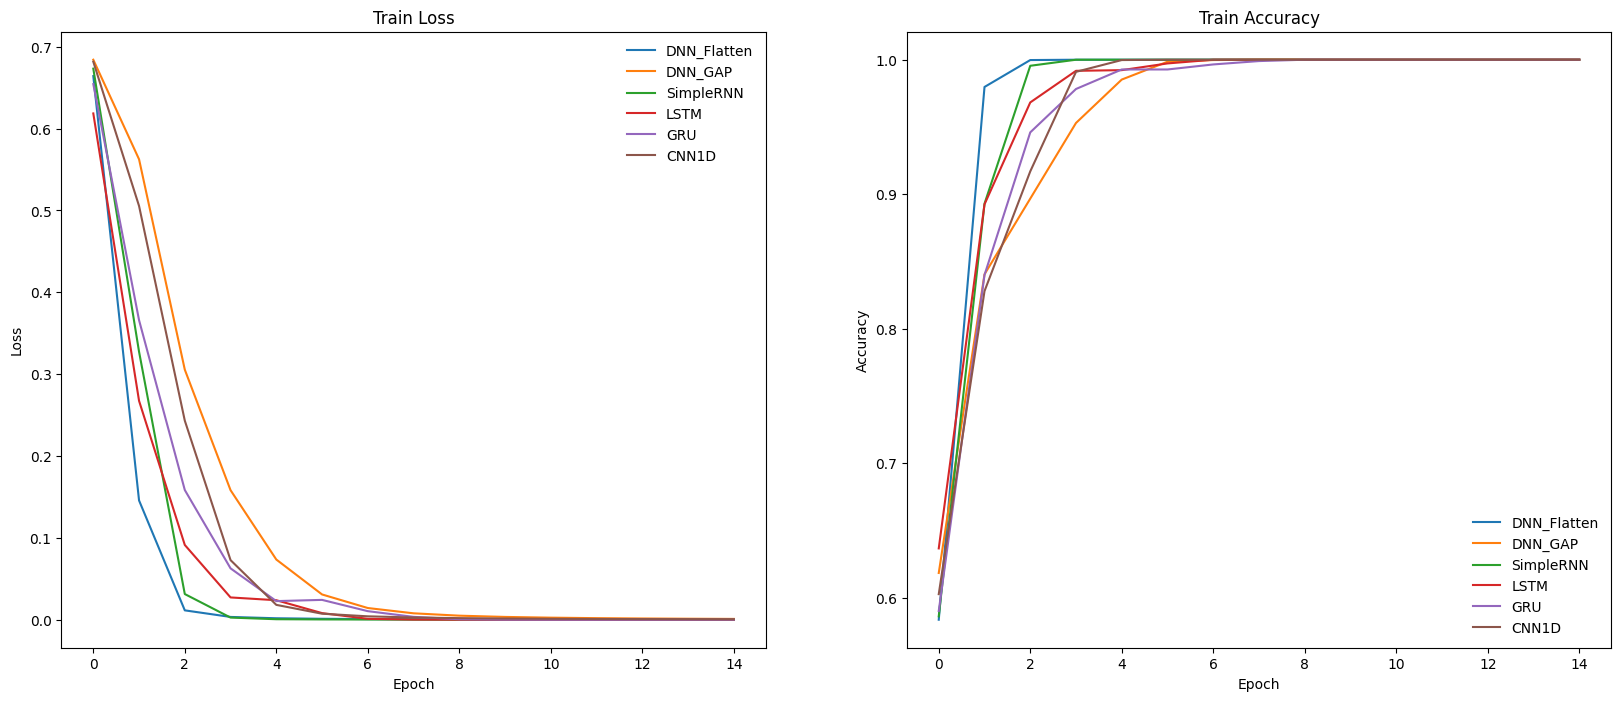

In [21]:
plot_model_comparision(histories, results, models)

In [26]:
def plot_model_comparision(histories, results, model_names):
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label={name})
        plt.plot(history.history['val_loss'], label=f'val_{name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend(frameon=False)

    plt.subplot(1,2,2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['acc'], label=name)
        plt.plot(history.history['val_acc'], label=name)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy')
    plt.legend(frameon=False)
    plt.show()

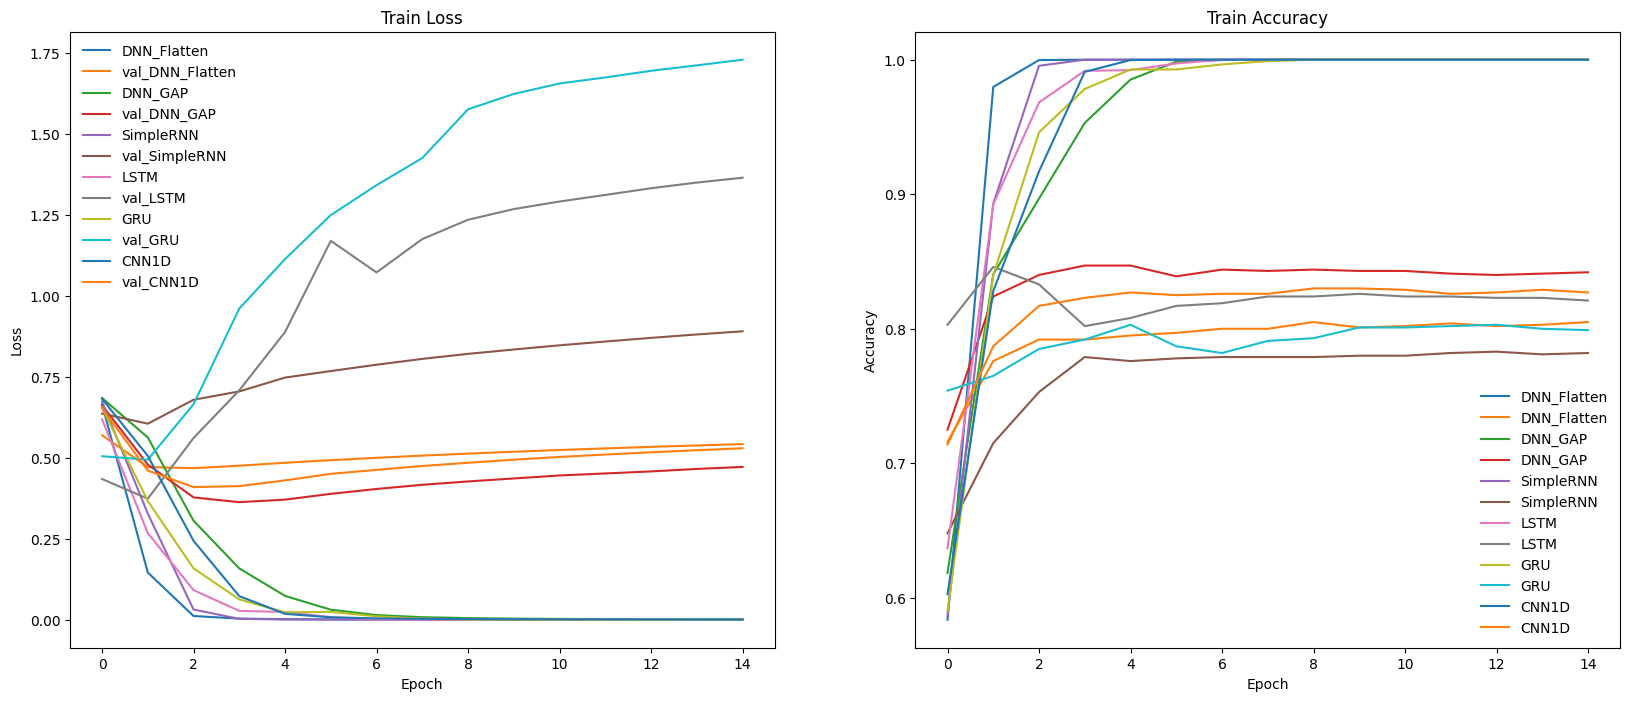

In [28]:
plot_model_comparision(histories, results, models)

In [27]:
df1=pd.DataFrame(model_name)
df1.columns=['model_name']

df2=pd.DataFrame(results)
df2.columns=['loss','accuracy']

df=pd.concat([df1,df2],axis=1)
print(df)

    model_name      loss  accuracy
0  DNN_Flatten  0.517173    0.8122
1      DNN_GAP  0.461515    0.8390
2    SimpleRNN  0.853136    0.7776
3         LSTM  1.367342    0.8168
4          GRU  1.657165    0.7946
5        CNN1D  0.498781    0.8290


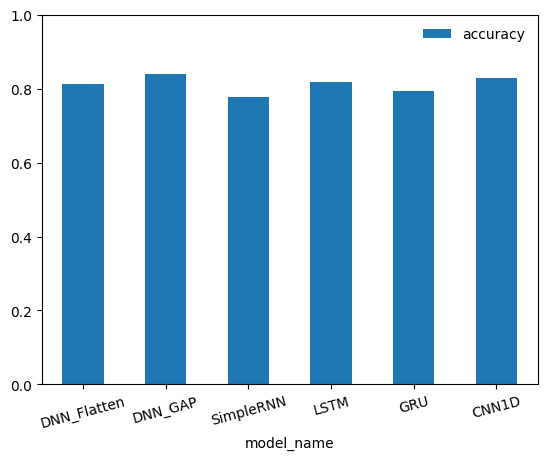

In [30]:
df.plot.bar(x='model_name', y='accuracy')
plt.ylim(0, 1)  # y축 범위 설정
plt.xticks(rotation=15)  # x축 라벨 각도 조정
plt.legend(frameon=False)
plt.show()

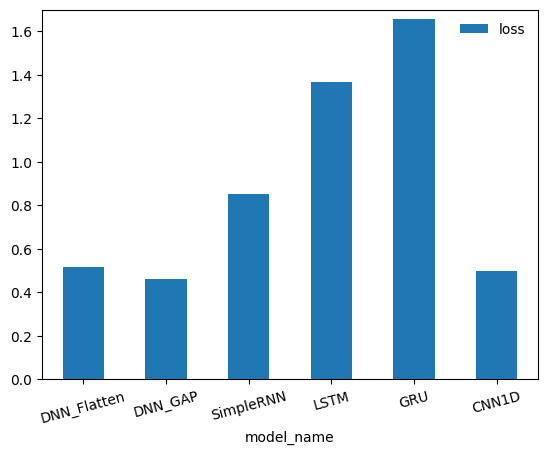

In [32]:
df.plot.bar(x='model_name',y='loss');
plt.ylim(0, 1.7)  # y축 범위 설정
plt.legend(frameon=False)
plt.xticks(rotation=15)  # x축 라벨 각도 조정
plt.show()